## How data scientists use BigQuery

This notebook accompanies the presentation 
["Machine Learning and Bayesian Statistics in minutes: How data scientists use BigQuery"](http://bit.ly/bigquery-datascience-talk)

### Bayesian Statistics in minutes

Let's say that we want to find the probability of a flight being late $\theta$ given a specific departure delay $\textbf{D}$ 
Bayes' Law tells that can be obtained for any specific departure delay using the formula:

<center><font size="+5">
$P(\theta|\textbf{D}) = P(\theta ) \frac{P(\textbf{D} |\theta)}{P(\textbf{D})} $
</font></center>

Once you have large datasets, the probabilities above are just exercises in counting and so, applying Bayesian statistics is super-easy in BigQuery. 

For example, let's find the probability that a flight will be 15+ minutes late: 

In [4]:
%%bigquery df
WITH rawnumbers AS (
SELECT
  departure_delay,
  COUNT(1) AS num_flights,
  COUNTIF(arrival_delay < 15) AS num_ontime
FROM
  `bigquery-samples.airline_ontime_data.flights`
GROUP BY
  departure_delay
HAVING
  num_flights > 100
),

totals AS (
SELECT
   SUM(num_flights) AS tot_flights,
   SUM(num_ontime) AS tot_ontime
FROM rawnumbers
),

bayes AS (
SELECT
  departure_delay,
  num_flights / tot_flights AS prob_D,
  num_ontime / tot_ontime AS prob_D_theta,
  tot_ontime / tot_flights AS prob_theta
FROM
  rawnumbers, totals
WHERE
  num_ontime > 0
)

SELECT
  *, (prob_theta * prob_D_theta / prob_D) AS prob_ontime
FROM
  bayes
ORDER BY
  departure_delay ASC

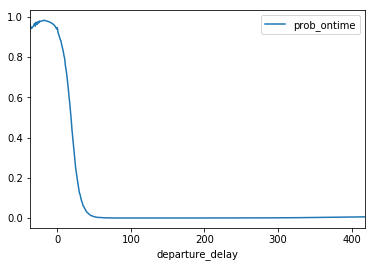

In [5]:
df.plot(x='departure_delay', y='prob_ontime');

But is it right, though? What's with the weird hump for early departures (departure_delay less than zero)?

First, we should verify that we can apply Bayes Law. Grouping by the departure delay is incorrect if the departure delay is a chaotic input variable. We have do exploratory analysis to validate that:

* If a flight departs late, will it arrive late?
* Is the relationship between the two variables non-chaotic?
* Does the linearity hold even for extreme values of departure delays?

This, too, is straightforward in BigQuery

In [7]:
%%bigquery df
SELECT
  departure_delay,
  COUNT(1) AS num_flights,
  APPROX_QUANTILES(arrival_delay, 10) AS arrival_delay_deciles
FROM
  `bigquery-samples.airline_ontime_data.flights`
GROUP BY
  departure_delay
HAVING
  num_flights > 100
ORDER BY
  departure_delay ASC

In [8]:
import pandas as pd
percentiles = df['arrival_delay_deciles'].apply(pd.Series)
percentiles = percentiles.rename(columns = lambda x : str(x*10) + "%")
df = pd.concat([df['departure_delay'], percentiles], axis=1)
df.head()

,departure_delay,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
0,-37.0,-66.0,-44.0,-41.0,-35.0,-30.0,-23.0,-17.0,-12.0,-3.0,6.0,33.0
1,-36.0,-74.0,-43.0,-39.0,-37.0,-32.0,-25.0,-18.0,-14.0,-7.0,2.0,49.0
2,-35.0,-68.0,-45.0,-40.0,-36.0,-28.0,-19.0,-14.0,-8.0,-4.0,3.0,85.0
3,-34.0,-58.0,-44.0,-40.0,-35.0,-30.0,-25.0,-19.0,-14.0,-8.0,2.0,39.0
4,-33.0,-59.0,-43.0,-39.0,-36.0,-32.0,-28.0,-20.0,-14.0,-7.0,5.0,25.0


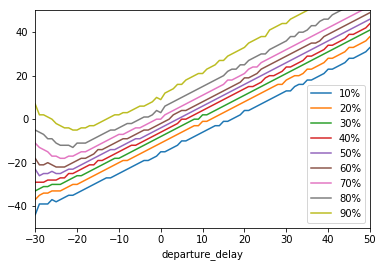

In [9]:
without_extremes = df.drop(['0%', '100%'], 1)
without_extremes.plot(x='departure_delay', xlim=(-30,50), ylim=(-50,50));

Note the crazy non-linearity for top half of of the flights that leave more than 20 minutes early. Most likely, these are planes that try to beat some weather situation. About half of such flights succeed (the linear bottom) and the other half don't (the non-linear top). The average is what we saw as the weird hump in the probability plot. So yes, the hump is real. The rest of the distribution is clear-cut and the Bayes probabilities are quite valid.

Solving the flights problem using GCP tools end-to-end (from ingest to machine learning) is covered in this book:
[<img src="https://aisoftwarellc.weebly.com/uploads/5/1/0/0/51003227/published/data-science-on-gcp_2.jpg?1563508887"></img>](https://www.amazon.com/Data-Science-Google-Cloud-Platform/dp/1491974567)

## Machine Learning in BigQuery

Here, we will use BigQuery ML to create a deep neural network that predicts the duration of bicycle rentals in London.

In [ ]:
%%bigquery
CREATE OR REPLACE MODEL ch09eu.bicycle_model_dnn
OPTIONS(input_label_cols=['duration'], 
        model_type='dnn_regressor', hidden_units=[32, 4])
TRANSFORM(
  duration
  , start_station_name
  , CAST(EXTRACT(dayofweek from start_date) AS STRING)
         as dayofweek
  , CAST(EXTRACT(hour from start_date) AS STRING)
         as hourofday    
)
AS
SELECT 
   duration, start_station_name, start_date
FROM 
  `bigquery-public-data`.london_bicycles.cycle_hire

In [10]:
%%bigquery
SELECT * FROM ML.EVALUATE(MODEL ch09eu.bicycle_model_dnn)

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,988.359648,1.410700e+08,0.924314,626.704285,0.000283,0.000283


In [13]:
%%bigquery
SELECT * FROM ML.PREDICT(MODEL ch09eu.bicycle_model_dnn,(
    SELECT 
    'Park Street, Bankside' AS start_station_name
    ,CURRENT_TIMESTAMP() AS start_date
))

,predicted_duration,start_station_name,start_date
0,1279.038818,"Park Street, Bankside",2019-08-27 03:51:21.657416+00:00


## BigQuery and TensorFlow

Batch predictions of a TensorFlow model from BigQuery!

In [ ]:
%%bigquery
CREATE OR REPLACE MODEL advdata.txtclass_tf
OPTIONS (model_type='tensorflow',
         model_path='gs://cloud-training-demos/txtclass/export/exporter/1549825580/*')

In [14]:
%%bigquery
SELECT
  input,
  (SELECT AS STRUCT(p, ['github', 'nytimes', 'techcrunch'][ORDINAL(s)]) prediction FROM
    (SELECT p, ROW_NUMBER() OVER() AS s FROM
      (SELECT * FROM UNNEST(dense_1) AS p)) 
  ORDER BY p DESC LIMIT 1).*
FROM ML.PREDICT(MODEL advdata.txtclass_tf,
(
SELECT 'Unlikely Partnership in House Gives Lawmakers Hope for Border Deal' AS input
UNION ALL SELECT "Fitbit\'s newest fitness tracker is just for employees and health insurance members"
UNION ALL SELECT "Show HN: Hello, a CLI tool for managing social media"
))

,input,prediction
0,Unlikely Partnership in House Gives Lawmakers ...,"{'_field_2': 'nytimes', '_field_1': 0.97631376..."
1,Fitbit's newest fitness tracker is just for em...,"{'_field_2': 'techcrunch', '_field_1': 0.99999..."
2,"Show HN: Hello, a CLI tool for managing social...","{'_field_2': 'github', '_field_1': 0.958878636..."


We use the bicycle rentals problem as a way to illustrate lots of BigQuery features in
[<img src="https://aisoftwarellc.weebly.com/uploads/5/1/0/0/51003227/published/bigquery-the-definitive-guide.jpg?1563508864"></img>](https://www.amazon.com/Google-BigQuery-Definitive-Warehousing-Analytics/dp/1492044466)

Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.